## Blog Review
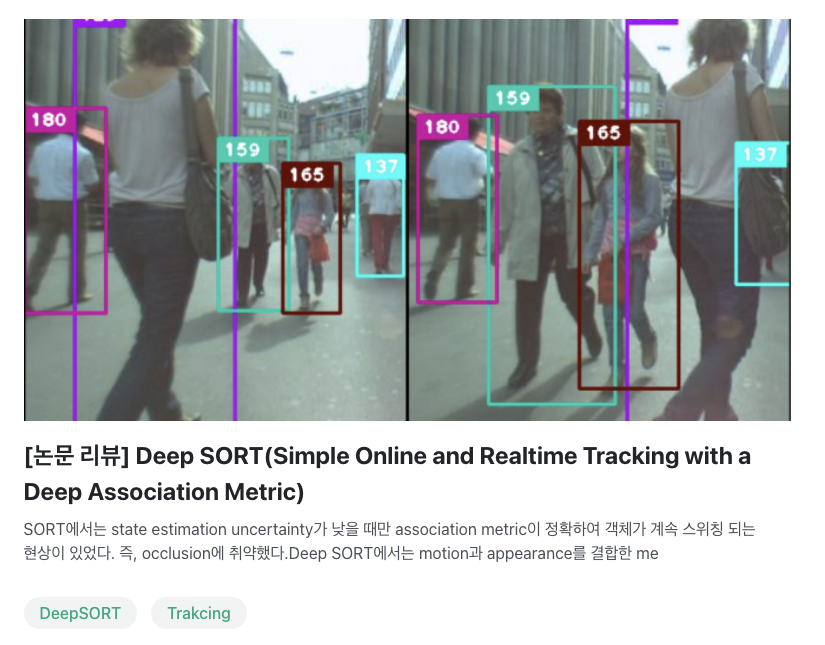
- <https://velog.io/@kimkj38>

# nn_matching.py

In [ ]:
import numpy as np

# 유클리디안 거리
def _pdist(a, b):
    """Compute pair-wise squared distance between points in `a` and `b`.
    Parameters
    ----------
    a : array_like
        An NxM matrix of N samples of dimensionality M.
    b : array_like
        An LxM matrix of L samples of dimensionality M.
    Returns
    -------
    ndarray
        Returns a matrix of size len(a), len(b) such that eleement (i, j)
        contains the squared distance between `a[i]` and `b[j]`.
    """
    a, b = np.asarray(a), np.asarray(b)
    if len(a) == 0 or len(b) == 0:
        return np.zeros((len(a), len(b)))
    a2, b2 = np.square(a).sum(axis=1), np.square(b).sum(axis=1)
    r2 = -2. * np.dot(a, b.T) + a2[:, None] + b2[None, :]
    r2 = np.clip(r2, 0., float(np.inf))
    return r2

# 코사인 유사도
def _cosine_distance(a, b, data_is_normalized=False):
    """Compute pair-wise cosine distance between points in `a` and `b`.
    Parameters
    ----------
    a : array_like
        An NxM matrix of N samples of dimensionality M.
    b : array_like
        An LxM matrix of L samples of dimensionality M.
    data_is_normalized : Optional[bool]
        If True, assumes rows in a and b are unit length vectors.
        Otherwise, a and b are explicitly normalized to lenght 1.
    Returns
    -------
    ndarray
        Returns a matrix of size len(a), len(b) such that eleement (i, j)
        contains the squared distance between `a[i]` and `b[j]`.
    """
    if not data_is_normalized:
        a = np.asarray(a) / np.linalg.norm(a, axis=1, keepdims=True)
        b = np.asarray(b) / np.linalg.norm(b, axis=1, keepdims=True)
    return 1. - np.dot(a, b.T)

# 최소 유클리디안
def _nn_euclidean_distance(x, y):
    """ Helper function for nearest neighbor distance metric (Euclidean).
    Parameters
    ----------
    x : ndarray
        A matrix of N row-vectors (sample points).
    y : ndarray
        A matrix of M row-vectors (query points).
    Returns
    -------
    ndarray
        A vector of length M that contains for each entry in `y` the
        smallest Euclidean distance to a sample in `x`.
    """
    distances = _pdist(x, y)
    return np.maximum(0.0, distances.min(axis=0))

# 최소 코사인
def _nn_cosine_distance(x, y):
    """ Helper function for nearest neighbor distance metric (cosine).
    Parameters
    ----------
    x : ndarray
        A matrix of N row-vectors (sample points).
    y : ndarray
        A matrix of M row-vectors (query points).
    Returns
    -------
    ndarray
        A vector of length M that contains for each entry in `y` the
        smallest cosine distance to a sample in `x`.
    """
    distances = _cosine_distance(x, y)
    return distances.min(axis=0)

# cost_matrix
class NearestNeighborDistanceMetric(object):
    """
    A nearest neighbor distance metric that, for each target, returns
    the closest distance to any sample that has been observed so far.
    Parameters
    ----------
    metric : str
        Either "euclidean" or "cosine".
    matching_threshold: float
        The matching threshold. Samples with larger distance are considered an
        invalid match.
    budget : Optional[int]
        If not None, fix samples per class to at most this number. Removes
        the oldest samples when the budget is reached.
    Attributes
    ----------
    samples : Dict[int -> List[ndarray]]
        A dictionary that maps from target identities to the list of samples
        that have been observed so far.
    """

    def __init__(self, metric, matching_threshold, budget=None):


        if metric == "euclidean":
            self._metric = _nn_euclidean_distance
        elif metric == "cosine":
            self._metric = _nn_cosine_distance
        else:
            raise ValueError(
                "Invalid metric; must be either 'euclidean' or 'cosine'")
        self.matching_threshold = matching_threshold
        self.budget = budget # 클래스 당 샘플 수를 고정. 오래된 샘플부터 지운다. 
        self.samples = {} 

    def partial_fit(self, features, targets, active_targets):
        """Update the distance metric with new data.
        Parameters
        ----------
        features : ndarray
            An NxM matrix of N features of dimensionality M.
        targets : ndarray
            An integer array of associated target identities.
        active_targets : List[int]
            A list of targets that are currently present in the scene.
        """
        
        # setdefault(a,b)
        # 딕셔너리에 a라는 key가 있으면 그에 해당하는 value 리턴, a가 없으면 default값 b 리턴        
        for feature, target in zip(features, targets):
            self.samples.setdefault(target, []).append(feature) # samples = {target(track_id): feature}
            if self.budget is not None:
                self.samples[target] = self.samples[target][-self.budget:] # 최근에 관측된 것들 budget수만큼 남긴다
        # confirmed track만 남긴다
        self.samples = {k: self.samples[k] for k in active_targets}
    
    # cost_matrix 생성
    def distance(self, features, targets):
        """Compute distance between features and targets.
        Parameters
        ----------
        features : ndarray
            An NxM matrix of N features of dimensionality M.
        targets : List[int]
            A list of targets to match the given `features` against.
        Returns
        -------
        ndarray
            Returns a cost matrix of shape len(targets), len(features), where
            element (i, j) contains the closest squared distance between
            `targets[i]` and `features[j]`.
        """
        cost_matrix = np.zeros((len(targets), len(features))) # cost_matrix 초기화(행이 tracks, 열이 detections)
        for i, target in enumerate(targets):
            cost_matrix[i, :] = self._metric(self.samples[target], features)
        return cost_matrix

# linear_assignment.py

In [ ]:
from __future__ import absolute_import
import numpy as np
# from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment as linear_assignment
from . import kalman_filter


INFTY_COST = 1e+5

# unmatched detections, unmatched_tracks, matches 구분
def min_cost_matching(
        distance_metric, max_distance, tracks, detections, track_indices=None,
        detection_indices=None):
    """Solve linear assignment problem.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection_indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : List[int]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above).
    detection_indices : List[int]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above).
    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    # index 없으면 생성
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    if len(detection_indices) == 0 or len(track_indices) == 0:
        return [], track_indices, detection_indices  # Nothing to match.

    # cost_matrix 생성
    cost_matrix = distance_metric(
        tracks, detections, track_indices, detection_indices)
    # max_distance보다 큰 cost는 max_distance로 수정
    cost_matrix[cost_matrix > max_distance] = max_distance + 1e-5
    # 행,열의 인덱스
    row_indices, col_indices = linear_assignment(cost_matrix)

    matches, unmatched_tracks, unmatched_detections = [], [], []
    
    # unmatched detections
    for col, detection_idx in enumerate(detection_indices):
        if col not in col_indices:
            unmatched_detections.append(detection_idx)
    
    # unmatched_tracks
    for row, track_idx in enumerate(track_indices):
        if row not in row_indices:
            unmatched_tracks.append(track_idx)
    
    # max_distance보다 큰 cost에 해당하는 track과 detection들은 unmatch 리스트로
    # 나머지는 matches 리스트로 (track_idx, detection_idx)
    for row, col in zip(row_indices, col_indices):
        track_idx = track_indices[row]
        detection_idx = detection_indices[col]
        if cost_matrix[row, col] > max_distance:
            unmatched_tracks.append(track_idx)
            unmatched_detections.append(detection_idx)
        else:
            matches.append((track_idx, detection_idx))
    return matches, unmatched_tracks, unmatched_detections


def matching_cascade(
        distance_metric, max_distance, cascade_depth, tracks, detections,
        track_indices=None, detection_indices=None):
    """Run matching cascade.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    cascade_depth: int
        The cascade depth, should be se to the maximum track age.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : Optional[List[int]]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above). Defaults to all tracks.
    detection_indices : Optional[List[int]]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above). Defaults to all
        detections.
    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    if track_indices is None:
        track_indices = list(range(len(tracks)))
    if detection_indices is None:
        detection_indices = list(range(len(detections)))

    # unmatched_detections를 초기화한다. 매칭 시 빼준다.
    unmatched_detections = detection_indices
    matches = []
    
    # age에 대해 반복문
    for level in range(cascade_depth):
        if len(unmatched_detections) == 0:  # No detections left
            break

        track_indices_l = [
            k for k in track_indices
            if tracks[k].time_since_update == 1 + level
        ]
        if len(track_indices_l) == 0:  # Nothing to match at this level
            continue

        matches_l, _, unmatched_detections = \
            min_cost_matching(
                distance_metric, max_distance, tracks, detections,
                track_indices_l, unmatched_detections)
        matches += matches_l
    unmatched_tracks = list(set(track_indices) - set(k for k, _ in matches))
    return matches, unmatched_tracks, unmatched_detections

# 카이제곱분포의 95% 신뢰구간만 고려하여 확률이 떨어지는 association 배제
def gate_cost_matrix(
        kf, cost_matrix, tracks, detections, track_indices, detection_indices,
        gated_cost=INFTY_COST, only_position=False):
    """Invalidate infeasible entries in cost matrix based on the state
    distributions obtained by Kalman filtering.
    Parameters
    ----------
    kf : The Kalman filter.
    cost_matrix : ndarray
        The NxM dimensional cost matrix, where N is the number of track indices
        and M is the number of detection indices, such that entry (i, j) is the
        association cost between `tracks[track_indices[i]]` and
        `detections[detection_indices[j]]`.
    tracks : List[track.Track]
        A list of predicted tracks at the current time step.
    detections : List[detection.Detection]
        A list of detections at the current time step.
    track_indices : List[int]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above).
    detection_indices : List[int]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above).
    gated_cost : Optional[float]
        Entries in the cost matrix corresponding to infeasible associations are
        set this value. Defaults to a very large value.
    only_position : Optional[bool]
        If True, only the x, y position of the state distribution is considered
        during gating. Defaults to False.
    Returns
    -------
    ndarray
        Returns the modified cost matrix.
    """

    
    """
    자유도에 따른 값
    chi2inv95 = {
    1: 3.8415,
    2: 5.9915,
    3: 7.8147,
    4: 9.4877,
    5: 11.070,
    6: 12.592,
    7: 14.067,
    8: 15.507,
    9: 16.919}
    
    """
    gating_dim = 2 if only_position else 4 # 카이제곱분포의 95% 신뢰구간
    gating_threshold = kalman_filter.chi2inv95[gating_dim]
    
    # detections의 xyah좌표 리스트
    measurements = np.asarray(
        [detections[i].to_xyah() for i in detection_indices])
    
    for row, track_idx in enumerate(track_indices):
        track = tracks[track_idx]
        # Compute gating distance between state distribution and measurements
        gating_distance = kf.gating_distance(
            track.mean, track.covariance, measurements, only_position)
        
        # 임계값보다 높으면 1e+5=7.718 높은 숫자??배제하는 방법?
        cost_matrix[row, gating_distance > gating_threshold] = gated_cost 
    return cost_matrix

# track.py

In [ ]:
class TrackState:
    """
    Enumeration type for the single target track state. Newly created tracks are
    classified as `tentative` until enough evidence has been collected. Then,
    the track state is changed to `confirmed`. Tracks that are no longer alive
    are classified as `deleted` to mark them for removal from the set of active
    tracks.
    """
    # 확실히 새로운 객체라고 인식하기 전까지는 Tentative, 확실한 객체에 대해서는 Confirmed, 사라진 객체는 Deleted로 분류
    Tentative = 1
    Confirmed = 2
    Deleted = 3


class Track:
    """
    A single target track with state space `(x, y, a, h)` and associated
    velocities, where `(x, y)` is the center of the bounding box, `a` is the
    aspect ratio and `h` is the height.
    Parameters
    ----------
    mean : ndarray
        Mean vector of the initial state distribution.
    covariance : ndarray
        Covariance matrix of the initial state distribution.
    track_id : int
        A unique track identifier.
    n_init : int
        Number of consecutive detections before the track is confirmed. The
        track state is set to `Deleted` if a miss occurs within the first
        `n_init` frames.
    max_age : int
        The maximum number of consecutive misses before the track state is
        set to `Deleted`.
    feature : Optional[ndarray]
        Feature vector of the detection this track originates from. If not None,
        this feature is added to the `features` cache.
    Attributes
    ----------
    mean : ndarray
        Mean vector of the initial state distribution.
    covariance : ndarray
        Covariance matrix of the initial state distribution.
    track_id : int
        A unique track identifier.
    hits : int
        Total number of measurement updates.
    age : int
        Total number of frames since first occurance.
    time_since_update : int
        Total number of frames since last measurement update.
    state : TrackState
        The current track state.
    features : List[ndarray]
        A cache of features. On each measurement update, the associated feature
        vector is added to this list.
    """

    def __init__(self, mean, covariance, track_id, n_init, max_age,
                 feature=None):
        self.mean = mean
        self.covariance = covariance
        self.track_id = track_id
        self.hits = 1 # measurement update 횟수
        self.age = 1  # 객체가 나타난 이후 frame의 수
        self.time_since_update = 0 # 마지막 measurement update 이후 frame의 수

        self.state = TrackState.Tentative
        self.features = []
        if feature is not None:
            self.features.append(feature)

        self._n_init = n_init   # Confirmed 상태가 되기까지 필요한 연속적인 매칭 frame의 수
        self._max_age = max_age # age>max_age가 되면(매칭이 오랫동안 안되면) Delete

    def to_tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
        width, height)`.
        Returns
        -------
        ndarray
            The bounding box.
        """
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    def to_tlbr(self):
        """Get current position in bounding box format `(min x, miny, max x,
        max y)`.
        Returns
        -------
        ndarray
            The bounding box.
        """
        ret = self.to_tlwh()
        ret[2:] = ret[:2] + ret[2:]
        return ret

    def predict(self, kf):
        """Propagate the state distribution to the current time step using a
        Kalman filter prediction step.
        Parameters
        ----------
        kf : kalman_filter.KalmanFilter
            The Kalman filter.
        """
        self.mean, self.covariance = kf.predict(self.mean, self.covariance)
        self.age += 1
        self.time_since_update += 1

    def update(self, kf, detection):
        """Perform Kalman filter measurement update step and update the feature
        cache.
        Parameters
        ----------
        kf : kalman_filter.KalmanFilter
            The Kalman filter.
        detection : Detection
            The associated detection.
        """
        self.mean, self.covariance = kf.update(
            self.mean, self.covariance, detection.to_xyah())
        self.features.append(detection.feature)

        self.hits += 1
        self.time_since_update = 0 # 업데이트 시 초기화. 이 값이 계속 늘어나면 Delete 된다.
        # Tentarive track이 n_init 이상의 hits를 가지면 Confrimed로 바뀐다
        if self.state == TrackState.Tentative and self.hits >= self._n_init:
            self.state = TrackState.Confirmed
    
    # Delete하는 경우들
    def mark_missed(self):
        """Mark this track as missed (no association at the current time step).
        """
        # Tentative track이 association 되지 않을 경우 Delete
        if self.state == TrackState.Tentative:
            self.state = TrackState.Deleted
        
        # max_age가 넘도록 assocation이 안될 경우 Delete
        elif self.time_since_update > self._max_age:
            self.state = TrackState.Deleted
    
    def is_tentative(self):
        """Returns True if this track is tentative (unconfirmed).
        """
        return self.state == TrackState.Tentative

    def is_confirmed(self):
        """Returns True if this track is confirmed."""
        return self.state == TrackState.Confirmed

    def is_deleted(self):
        """Returns True if this track is dead and should be deleted."""
        return self.state == TrackState.Deleted

# tracker.py

In [ ]:
from __future__ import absolute_import
import numpy as np
from . import kalman_filter
from . import linear_assignment
from . import iou_matching
from .track import Track


class Tracker:
    """
    This is the multi-target tracker.
    Parameters
    ----------
    metric : nn_matching.NearestNeighborDistanceMetric
        A distance metric for measurement-to-track association.
    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of consecutive detections before the track is confirmed. The
        track state is set to `Deleted` if a miss occurs within the first
        `n_init` frames.
    Attributes
    ----------
    metric : nn_matching.NearestNeighborDistanceMetric
        The distance metric used for measurement to track association.
    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of frames that a track remains in initialization phase.
    kf : kalman_filter.KalmanFilter
        A Kalman filter to filter target trajectories in image space.
    tracks : List[Track]
        The list of active tracks at the current time step.
    """

    def __init__(self, metric, max_iou_distance=0.7, max_age=70, n_init=3):
        self.metric = metric
        self.max_iou_distance = max_iou_distance
        self.max_age = max_age
        self.n_init = n_init

        self.kf = kalman_filter.KalmanFilter()
        self.tracks = []
        self._next_id = 1

    def predict(self):
        """Propagate track state distributions one time step forward.
        This function should be called once every time step, before `update`.
        """
        for track in self.tracks:
            track.predict(self.kf)

    def update(self, detections):
        """Perform measurement update and track management.
        Parameters
        ----------
        detections : List[deep_sort.detection.Detection]
            A list of detections at the current time step.
        """
        # Run matching cascade.
        matches, unmatched_tracks, unmatched_detections = \
            self._match(detections)

        # 매칭된 track 업데이트
        for track_idx, detection_idx in matches:
            self.tracks[track_idx].update(
                self.kf, detections[detection_idx])
        
        # 매칭 안된 track 삭제(Tentetive는 즉시, Confirmed는 time_since_update > max_age의 경우만)
        for track_idx in unmatched_tracks:
            self.tracks[track_idx].mark_missed()
        
        # 매칭 안된 detection은 새로운 track으로 인지
        for detection_idx in unmatched_detections:
            self._initiate_track(detections[detection_idx])
        
        # delete된 track들 리스트에서 제거
        self.tracks = [t for t in self.tracks if not t.is_deleted()]

        # Update distance metric.
        # confirmed track에 대해서만 수행. 코사인 유사도.
        active_targets = [t.track_id for t in self.tracks if t.is_confirmed()]
        features, targets = [], []
        for track in self.tracks:
            if not track.is_confirmed():
                continue
            features += track.features
            targets += [track.track_id for _ in track.features]
            track.features = []
            
        # samples={target(track_id): feature 리스트}, confirmed track에 대해서만 
        self.metric.partial_fit(
            np.asarray(features), np.asarray(targets), active_targets)

    def _match(self, detections):

        def gated_metric(tracks, dets, track_indices, detection_indices):
            # features, targets 도출
            features = np.array([dets[i].feature for i in detection_indices]) 
            targets = np.array([tracks[i].track_id for i in track_indices])   
            
            # cost_matrix 구하기
            cost_matrix = self.metric.distance(features, targets)
            
            # 카이제곱분포 threshold
            cost_matrix = linear_assignment.gate_cost_matrix(
                self.kf, cost_matrix, tracks, dets, track_indices,
                detection_indices)

            return cost_matrix

        # confirmed_tarcks와 unconfirmed_tracks 구분 
        confirmed_tracks = [
            i for i, t in enumerate(self.tracks) if t.is_confirmed()]
        unconfirmed_tracks = [
            i for i, t in enumerate(self.tracks) if not t.is_confirmed()]

        # features 이용하여 confirmed track들 associate
        matches_a, unmatched_tracks_a, unmatched_detections = \
            linear_assignment.matching_cascade(
                gated_metric, self.metric.matching_threshold, self.max_age,
                self.tracks, detections, confirmed_tracks)

        # IOU 이용하여 unmatched and unconfirmed tracks와 unmatched detection associate
        iou_track_candidates = unconfirmed_tracks + [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update == 1] 
        unmatched_tracks_a = [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update != 1]
        matches_b, unmatched_tracks_b, unmatched_detections = \
            linear_assignment.min_cost_matching(
                iou_matching.iou_cost, self.max_iou_distance, self.tracks,
                detections, iou_track_candidates, unmatched_detections)

        matches = matches_a + matches_b
        unmatched_tracks = list(set(unmatched_tracks_a + unmatched_tracks_b))
        return matches, unmatched_tracks, unmatched_detections

    # 새로운 track
    def _initiate_track(self, detection):
        mean, covariance = self.kf.initiate(detection.to_xyah())
        self.tracks.append(Track(
            mean, covariance, self._next_id, self.n_init, self.max_age,
            detection.feature))
        self._next_id += 1

# deepsort.py

In [ ]:
import numpy as np
import torch

from .deep.feature_extractor import Extractor
from .sort.nn_matching import NearestNeighborDistanceMetric
from .sort.preprocessing import non_max_suppression
from .sort.detection import Detection
from .sort.tracker import Tracker


__all__ = ['DeepSort']


class DeepSort(object):
    def __init__(self, model_path, max_dist=0.2, min_confidence=0.3, nms_max_overlap=1.0, max_iou_distance=0.7, max_age=70, n_init=3, nn_budget=100, use_cuda=True):
        self.min_confidence = min_confidence
        self.nms_max_overlap = nms_max_overlap

        self.extractor = Extractor(model_path, use_cuda=use_cuda)

        max_cosine_distance = max_dist
        nn_budget = 100
        metric = NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
        self.tracker = Tracker(metric, max_iou_distance=max_iou_distance, max_age=max_age, n_init=n_init)

    def update(self, bbox_xywh, confidences, ori_img):
        self.height, self.width = ori_img.shape[:2]
        # generate detections
        features = self._get_features(bbox_xywh, ori_img) # bbox의 특징벡터 추출
        bbox_tlwh = self._xywh_to_tlwh(bbox_xywh)
        
        # min_confidence 이상의 detection들만 뽑아낸다
        detections = [Detection(bbox_tlwh[i], conf, features[i]) for i,conf in enumerate(confidences) if conf>self.min_confidence]

        # run on non-maximum supression(IOU가 nms_max_overlap 이상인 것들 삭제)
        boxes = np.array([d.tlwh for d in detections])
        scores = np.array([d.confidence for d in detections])
        indices = non_max_suppression(boxes, self.nms_max_overlap, scores)
        detections = [detections[i] for i in indices]

        # update tracker
        self.tracker.predict()
        self.tracker.update(detections)

        # output bbox identities
        # 계속 매칭이 되었던 confirmed track들 ouput에 넣어준다
        outputs = []
        for track in self.tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            box = track.to_tlwh()
            x1,y1,x2,y2 = self._tlwh_to_xyxy(box)
            track_id = track.track_id
            outputs.append(np.array([x1,y1,x2,y2,track_id], dtype=np.int))
        if len(outputs) > 0:
            outputs = np.stack(outputs,axis=0)
        return outputs


    """
    TODO:
        Convert bbox from xc_yc_w_h to xtl_ytl_w_h
    Thanks JieChen91@github.com for reporting this bug!
    """
    @staticmethod
    # (cx,cy,w,h) -> (topleft_x, topleft_y, w, h) 
    def _xywh_to_tlwh(bbox_xywh):
        if isinstance(bbox_xywh, np.ndarray):
            bbox_tlwh = bbox_xywh.copy()
        elif isinstance(bbox_xywh, torch.Tensor):
            bbox_tlwh = bbox_xywh.clone()
        bbox_tlwh[:,0] = bbox_xywh[:,0] - bbox_xywh[:,2]/2.
        bbox_tlwh[:,1] = bbox_xywh[:,1] - bbox_xywh[:,3]/2.
        return bbox_tlwh


    def _xywh_to_xyxy(self, bbox_xywh):
        x,y,w,h = bbox_xywh
        x1 = max(int(x-w/2),0)
        x2 = min(int(x+w/2),self.width-1)
        y1 = max(int(y-h/2),0)
        y2 = min(int(y+h/2),self.height-1)
        return x1,y1,x2,y2

    def _tlwh_to_xyxy(self, bbox_tlwh):
        """
        TODO:
            Convert bbox from xtl_ytl_w_h to xc_yc_w_h
        Thanks JieChen91@github.com for reporting this bug!
        """
        x,y,w,h = bbox_tlwh
        x1 = max(int(x),0)
        x2 = min(int(x+w),self.width-1)
        y1 = max(int(y),0)
        y2 = min(int(y+h),self.height-1)
        return x1,y1,x2,y2

    def _xyxy_to_tlwh(self, bbox_xyxy):
        x1,y1,x2,y2 = bbox_xyxy

        t = x1
        l = y1
        w = int(x2-x1)
        h = int(y2-y1)
        return t,l,w,h
    
    def _get_features(self, bbox_xywh, ori_img):
        im_crops = []
        for box in bbox_xywh:
            x1,y1,x2,y2 = self._xywh_to_xyxy(box)
            im = ori_img[y1:y2,x1:x2] # original image의 크기에 맞게 crop
            im_crops.append(im)
        if im_crops:
            features = self.extractor(im_crops) # crop한 이미지에서 특징 추출
        else:
            features = np.array([])
        return features